In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/ppc_fashionmnist_config.json")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
trainer.fit(model, data, ckpt_path="saved/models/FashionMnist_Ppc/0521_195417/checkpoint_1999.ckpt")

Missing logger folder: saved/log/FashionMnist_Ppc/0521_213504/lightning_logs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/FashionMnist_Ppc/0521_213504 exists and is not empty.
Restoring states from the checkpoint path at saved/models/FashionMnist_Ppc/0521_195417/checkpoint_1999.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:361: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/FashionMnist_Ppc/0521_195417' to '/workspace/shai_hulud/ppc_experiments/saved/models/FashionMnist_Ppc/0521_213504', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type       | Params
------------------------------------------
0 | g

Sanity Checking: |                                                                                            …

`Trainer.fit` stopped: `max_epochs=2000` reached.


In [6]:
model.graph.clear()
model.eval()

LightningPpc(
  (graph): MnistPpc(
    (prior): GaussianPrior()
    (decoder1): ConditionalGaussian(
      (decoder): Sequential(
        (0): ReLU()
        (1): Linear(in_features=20, out_features=128, bias=True)
      )
    )
    (decoder2): ConditionalGaussian(
      (decoder): Sequential(
        (0): ReLU()
        (1): Linear(in_features=128, out_features=256, bias=True)
      )
    )
    (likelihood): MlpBernoulliLikelihood(
      (decoder): Sequential(
        (0): ReLU()
        (1): Linear(in_features=256, out_features=784, bias=True)
      )
    )
  )
  (predictive): Predictive()
)

In [7]:
SEEDS = [123, 456, 789, 101112, 131415]

In [8]:
import utils

In [9]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [10]:
for (s, SEED) in enumerate(SEEDS):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    for (xs, target, indices) in data.val_dataloader():
        model._load_particles(indices, False)

        clamps = {k: v['value'] for k, v in model.graph.nodes.items()
                  if k != 'X'}
        with model.graph.condition(**clamps) as predictive:
            x_hats = predictive(B=len(xs), mode="prior", P=model.num_particles)
        x_hats = x_hats.mean(dim=0).cpu()
        LOG_LIKELIHOODS[s] += -torch.nn.functional.binary_cross_entropy(x_hats, xs, reduction="none").sum()
        MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean()

    LOG_LIKELIHOODS[s] /= len(data.val_dataloader().sampler)
    MEAN_SQUARED_ERROR[s] /= len(data.val_dataloader().sampler)

In [11]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-382.1067), tensor(0.0919))

In [12]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(0.0757), tensor(4.1959e-05))

In [13]:
import matplotlib.pyplot as plt

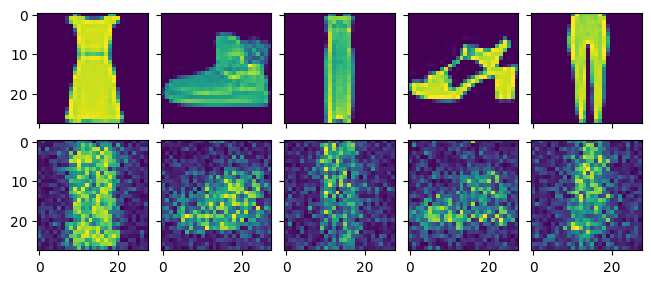

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex="all", sharey="all", layout="compressed")

for i in range(5):
    axes[0, i].imshow(xs[i].squeeze().detach().numpy())
    axes[1, i].imshow(x_hats[i].squeeze().detach().numpy())

fig.savefig("ppc_fashionmnist_recons.pdf", bbox_inches="tight")
plt.show()

In [15]:
model.graph.clear()

In [16]:
x_hats = model.graph(B=len(xs), mode="prior", P=model.num_particles)

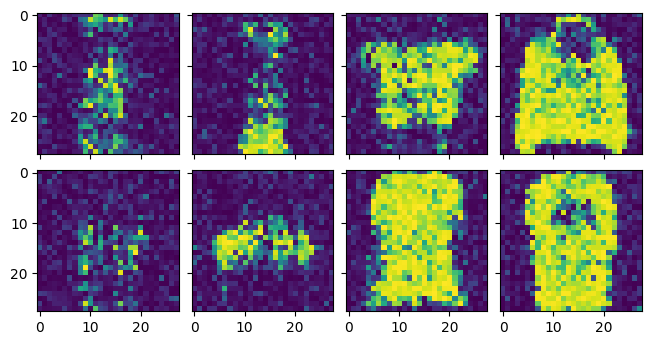

In [17]:
fig, axes = plt.subplots(nrows=model.num_particles, ncols=4, sharex="all", sharey="all", layout="compressed")

for i in range(model.num_particles):
    for j in range(4):
        axes[i, j].imshow(x_hats[i, j].squeeze().detach().numpy())

fig.savefig("ppc_fashionmnist_samples.pdf", bbox_inches="tight")
plt.show()